In [59]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
print(f'torch version: {torch.__version__}')

#Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

torch version: 1.13.0
using device: cuda


In [60]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
print(data.shape)
data.head()

np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

raw_numpy= data.to_numpy()
np.random.shuffle(raw_numpy)
raw_torch = torch.tensor(raw_numpy)
X = raw_torch[:, 1:].type(torch.float) / 255.
y = raw_torch[:, 0].type(torch.long)
print(f"X.shape: {X.shape}, y.shape, {y.shape}")
train_split = int(0.8*len(X))
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(42000, 785)
X.shape: torch.Size([42000, 784]), y.shape, torch.Size([42000])
torch.Size([33600, 784]) torch.Size([8400, 784]) torch.Size([33600]) torch.Size([8400])


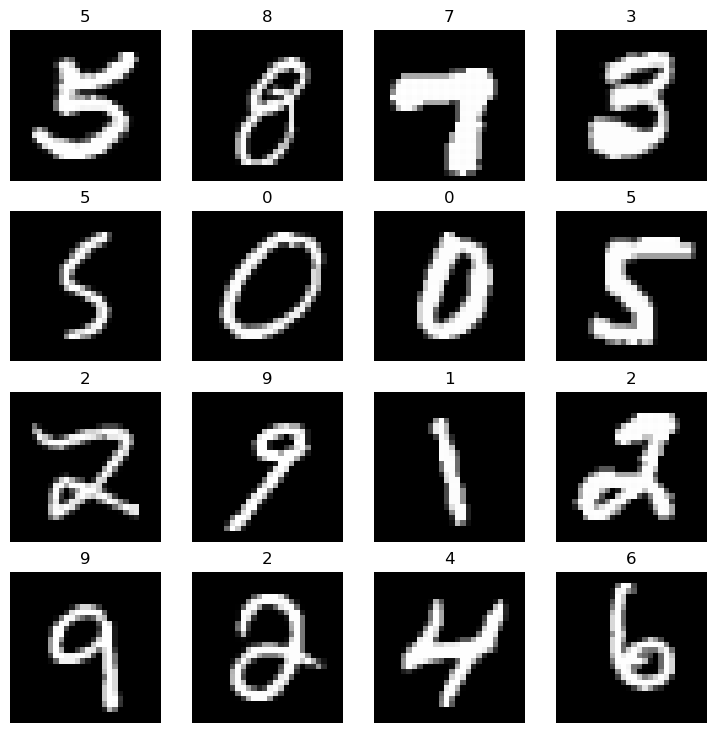

In [61]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(X_train), size = [1]).item()
    img  = torch.mul(X_train[random_idx].reshape((28, 28)), 255)
    label = y_train[random_idx].item()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.cpu(), cmap = "gray")
    plt.title(label)
    plt.axis(False)

In [62]:
from torch.utils.data import Dataset, DataLoader
"""
Trigger warning :::
This is the worst implementation of a PyTorch Custom Dataset
you'll ever see lol
"""
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.data[idx]
        return [data, label]
        sample = {"Data": data, "Class": label}
        return sample
    
    
### Hyperparameters
BATCH_SIZE = 2048

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)


train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle = True,
                              drop_last = True) #drop_last = True
test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              drop_last = True) #drop_last = True

print(f"Length of train_dataloader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of size {BATCH_SIZE}")

train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)
print(test_features_batch.shape, test_labels_batch.shape)

Length of train_dataloader: 16 batches of size 2048
Length of test_dataloader: 4 batches of size 2048
torch.Size([2048, 784]) torch.Size([2048])
torch.Size([2048, 784]) torch.Size([2048])


In [63]:
# Batch normalization
#Let us use B to denote a mini-batch of size m of the entire training set.
#The empirical mean and variance of B could thus be denoted as
#mu_B = 1/m sum(x_i), sigma_B = sum((x_i-m_B)^2)
#x_i := (x_i - mu_B)/sigma_B

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"On device: {device}")

#Already "normalized" inputs to values 0-1
#nn.ReLU(), nn.Sigmoid(), nn.BatchNormalization(), nn.Dropout(0.25),

np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

class AudoencoderV3(nn.Module):
    def __init__(self,
                 bottleneck: int):
        super().__init__()
        
        l1 = 128
        l2 = 64
        l3 = 32
        bottleneck = 16
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784,
                      out_features=l1),
            nn.BatchNorm1d(num_features = l1, affine = False),
            nn.Linear(in_features = l1,
                      out_features = l2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = l2, affine = False),
            nn.Linear(in_features = l2,
                      out_features = l3),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = l3, affine = False),
            nn.Linear(in_features = l3,
                      out_features = bottleneck),
            nn.BatchNorm1d(num_features = bottleneck)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=bottleneck,
                      out_features=l3),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = l3, affine = False),
            nn.Linear(in_features=l3,
                      out_features=l2),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = l2, affine = False),
            nn.Linear(in_features = l2,
                      out_features = l1),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = l1, affine = False),
            nn.Linear(in_features = l1,
                      out_features = 784),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.decoder(self.encoder(x))

model_0 = AudoencoderV3(bottleneck=500).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
model_0

On device: cuda


AudoencoderV3(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affi

In [65]:
from tqdm.auto import tqdm #progress bar
import time
t1 = time.time()
lrs = []

epochs = 150
for epoch in tqdm(range(epochs)):
    for batch, (X, y) in enumerate(train_dataloader):
        X=X.to(device)
        
        model_0.train()
        #1. Forward pass
        y_pred = model_0(X)
        #2 Calculate loss (per batch)
        loss = loss_fn(y_pred, X)
        #3. Optimizer zero grad
        optimizer.zero_grad()
        #4. Loss backward
        loss.backward()
        #5. Optimizer step
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
        
    model_0.eval()  
    if True:
        train_loss = 0
        test_loss = 0

        with torch.inference_mode(): #context manager
            for X_t, _ in train_dataloader:
                X_t = X_t.to(device)
                y_t_pred = model_0(X_t)
                loss_t = loss_fn(y_t_pred, X_t)
                train_loss+=loss_t #accumulate train loss
            for X_test, _ in test_dataloader:
                X_test = X_test.to(device)
                y_test_pred = model_0(X_test)
                loss_test = loss_fn(y_test_pred, X_test)
                test_loss+=loss_test #accumulate train loss

            train_loss /= len(train_dataloader)
            test_loss /= len(test_dataloader)
        cur_lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Learning rate: {cur_lr}")
            
print(f'Taken {float(time.time()-t1):.5f} seconds.')


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.0169 | Test loss: 2.0150 | Learning rate: 0.1
Epoch: 1 | Train loss: 0.1678 | Test loss: 0.1661 | Learning rate: 0.1
Epoch: 2 | Train loss: 0.0876 | Test loss: 0.0872 | Learning rate: 0.1
Epoch: 3 | Train loss: 0.0713 | Test loss: 0.0711 | Learning rate: 0.1
Epoch: 4 | Train loss: 0.0664 | Test loss: 0.0662 | Learning rate: 0.1
Epoch: 5 | Train loss: 0.0621 | Test loss: 0.0619 | Learning rate: 0.1
Epoch: 6 | Train loss: 0.0601 | Test loss: 0.0599 | Learning rate: 0.1
Epoch: 7 | Train loss: 0.0570 | Test loss: 0.0569 | Learning rate: 0.1
Epoch: 8 | Train loss: 0.0554 | Test loss: 0.0551 | Learning rate: 0.1
Epoch: 9 | Train loss: 0.0518 | Test loss: 0.0517 | Learning rate: 0.05
Epoch: 10 | Train loss: 0.0505 | Test loss: 0.0503 | Learning rate: 0.05
Epoch: 11 | Train loss: 0.0496 | Test loss: 0.0494 | Learning rate: 0.05
Epoch: 12 | Train loss: 0.0480 | Test loss: 0.0478 | Learning rate: 0.05
Epoch: 13 | Train loss: 0.0479 | Test loss: 0.0477 | Learning rate: 0.

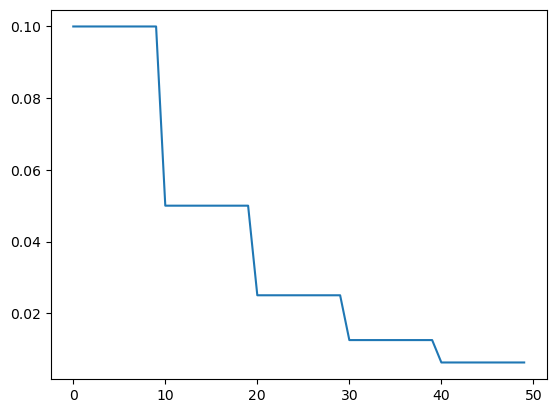

In [68]:
plt.plot(lrs)

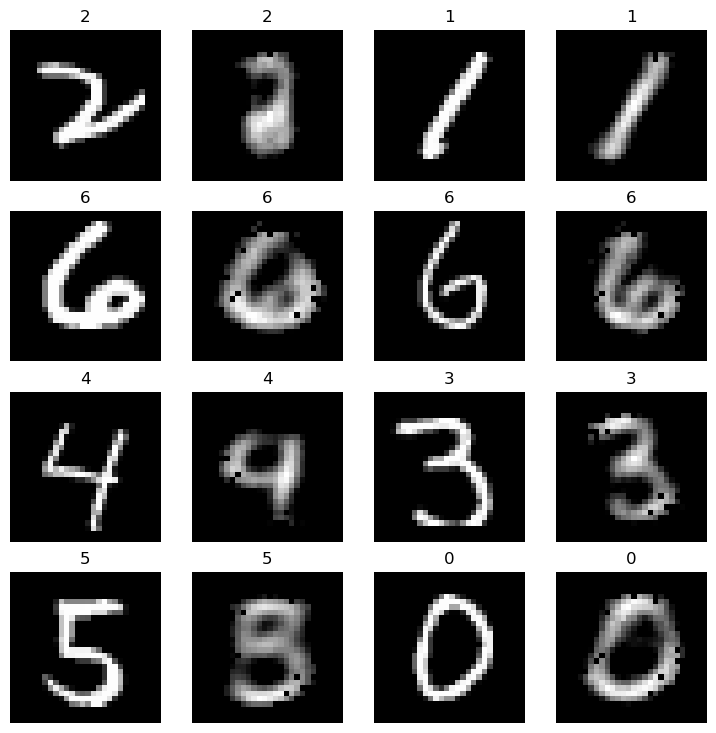

In [70]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
X=X.to(device)
model_0.eval()
with torch.inference_mode():
    all_pred = model_0(X)
for i in range(1, rows*cols+1, 2):
    cur = X[i]
    pred = all_pred[i]
    img_real =  torch.mul(cur.reshape((28, 28)), 255)
    img_pred = torch.mul(pred.reshape((28, 28)), 255)
    label = y[i].item()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img_real.cpu().detach().numpy(), cmap = "gray")
    plt.title(label)
    plt.axis(False)
    
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img_pred.cpu().detach().numpy(), cmap = "gray")
    plt.title(label)
    plt.axis(False)

In [ ]:
cur.shape

In [ ]:
model_0(X).shape